In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [3]:
def build_mongolian_tent_graph(n):
    if n % 2 == 0:
        raise ValueError("n must be odd for a valid Mongolian tent graph.")

    graph = {}
    
    # Grid vertices: rows 0, 1, 2 and columns 0 to n-1
    def node_id(row, col):
        return row * n + col

    # Step 1: Build the grid P_3 x P_n
    for row in range(3):
        for col in range(n):
            curr = node_id(row, col)
            graph[curr] = []

            # Connect to right neighbor
            if col + 1 < n:
                graph[curr].append(node_id(row, col + 1))
            
            # Connect to bottom neighbor
            if row + 1 < 3:
                graph[curr].append(node_id(row + 1, col))

            # Connect left and top neighbors (implicitly)
            if col - 1 >= 0:
                graph[curr].append(node_id(row, col - 1))
            if row - 1 >= 0:
                graph[curr].append(node_id(row - 1, col))

    # Step 2: Add the tent peak node and connect to every top-row vertex
    tent_peak = 3 * n
    graph[tent_peak] = []
    for col in range(0, n):
        top_row_node = node_id(0, col)
        graph[tent_peak].append(top_row_node)
        graph[top_row_node].append(tent_peak)

    return graph

In [14]:
n = 5
graph = build_mongolian_tent_graph(n)
graph

{0: [1, 5, 15],
 1: [2, 6, 0, 15],
 2: [3, 7, 1, 15],
 3: [4, 8, 2, 15],
 4: [9, 3, 15],
 5: [6, 10, 0],
 6: [7, 11, 5, 1],
 7: [8, 12, 6, 2],
 8: [9, 13, 7, 3],
 9: [14, 8, 4],
 10: [11, 5],
 11: [12, 10, 6],
 12: [13, 11, 7],
 13: [14, 12, 8],
 14: [13, 9],
 15: [0, 1, 2, 3, 4]}

In [11]:
def compute_edges(graph):
    """Convert adjacency list to undirected edge list without duplicates"""
    edges = set()
    for u in graph:
        for v in graph[u]:
            if u < v:
                edges.add((u, v))
    return list(edges)

def max_degree(graph):
    return max(len(neighbors) for neighbors in graph.values())

def label_graph(graph, k):
    vertices = list(graph.keys())
    vertices.sort(key=lambda v: -len(graph[v]))
    n = len(vertices)
    edges = compute_edges(graph)
    max_weight = 2 * k

    def is_valid_labeling(idx, labels, used_weights):
        if idx == n:
            return True

        v = vertices[idx]
        for label in range(1, k + 1):
            labels[v] = label
            valid = True
            new_weights = []

            for u in graph[v]:
                if u in labels:
                    w = labels[v] + labels[u]
                    if w > max_weight or used_weights[w]:
                        valid = False
                        break
                    new_weights.append(w)

            if valid:
                for w in new_weights:
                    used_weights[w] = True
                if is_valid_labeling(idx + 1, labels, used_weights):
                    return True
                for w in new_weights:
                    used_weights[w] = False

            del labels[v]

        return False

    used_weights = [False] * (max_weight + 1)
    labels = {}
    success = is_valid_labeling(0, labels, used_weights)
    return success, labels if success else None


def find_edge_irregularity_strength(graph):
    """Find minimal k where valid vertex k-labeling gives unique edge weights"""
    edges = compute_edges(graph)
    edge_count = len(edges)
    delta = max_degree(graph)

    lower = max(math.ceil((edge_count + 1) / 2), delta)
    upper = 2 * edge_count

    pbar = tqdm(total=upper - lower + 1, desc="Searching k")

    while lower < upper:
        mid = (lower + upper) // 2
        pbar.set_postfix({"k": mid})
        success, labels = label_graph(graph, mid)
        if success:
            upper = mid
        else:
            lower = mid + 1
        pbar.update(1)

    pbar.close()
    return lower, labels

def draw_labeled_tent_graph(graph, n, labels):
    G = nx.Graph()

    # Add labeled nodes
    for node in graph:
        G.add_node(node)

    # Add edges
    for u in graph:
        for v in graph[u]:
            if u < v:
                G.add_edge(u, v)

    # Custom layout for Mongolian Tent structure
    pos = {}
    for row in range(3):
        for col in range(n):
            node = row * n + col
            pos[node] = (col, -row)

    tent_peak = 3 * n
    pos[tent_peak] = ((n - 1) / 2, 1)

    # Compute edge weights
    edge_labels = {
        (u, v): labels[u] + labels[v]
        for u, v in G.edges()
    }

    # Draw base graph
    plt.figure(figsize=(1.5 * n, 4))
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_color="lightcoral", node_size=900, font_size=10, font_weight="bold")

    # Draw edge weights
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=10)

    # Title and formatting
    plt.title(f"Mongolian Tent Graph M₃,{n} with Vertex k-Labeling", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Searching k:  15%|█▍        | 6/41 [00:00<00:00, 1160.36it/s, k=14]

Edge irregularity strength es(G): 14



/tmp/ipykernel_88293/703437048.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


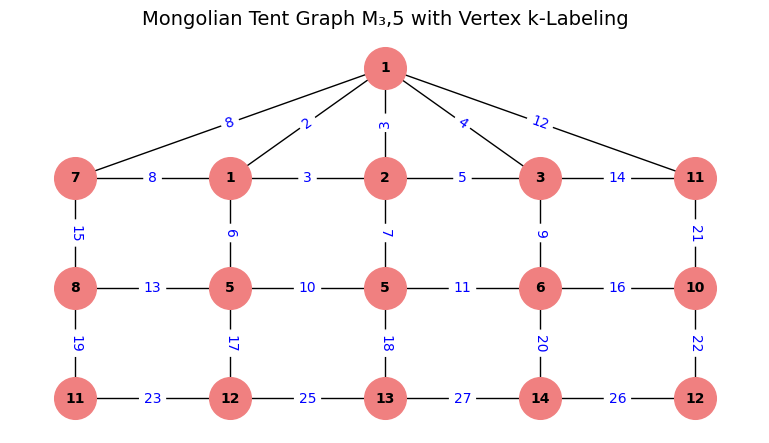

In [12]:
es, labels = find_edge_irregularity_strength(graph)
print(f"Edge irregularity strength es(G): {es}")
draw_labeled_tent_graph(graph, 5, labels)